In [1]:
%matplotlib inline
import sys
import os
sys.path.append("/Users/chernals/cernbox/Work/packages")
sys.path.append("/Users/chernals/cernbox/Work/packages/georges")
import matplotlib.pyplot as plt
import georges
PATH = "/Users/chernals/Dropbox/IBA/Work/IBA-Optics/beamlines"

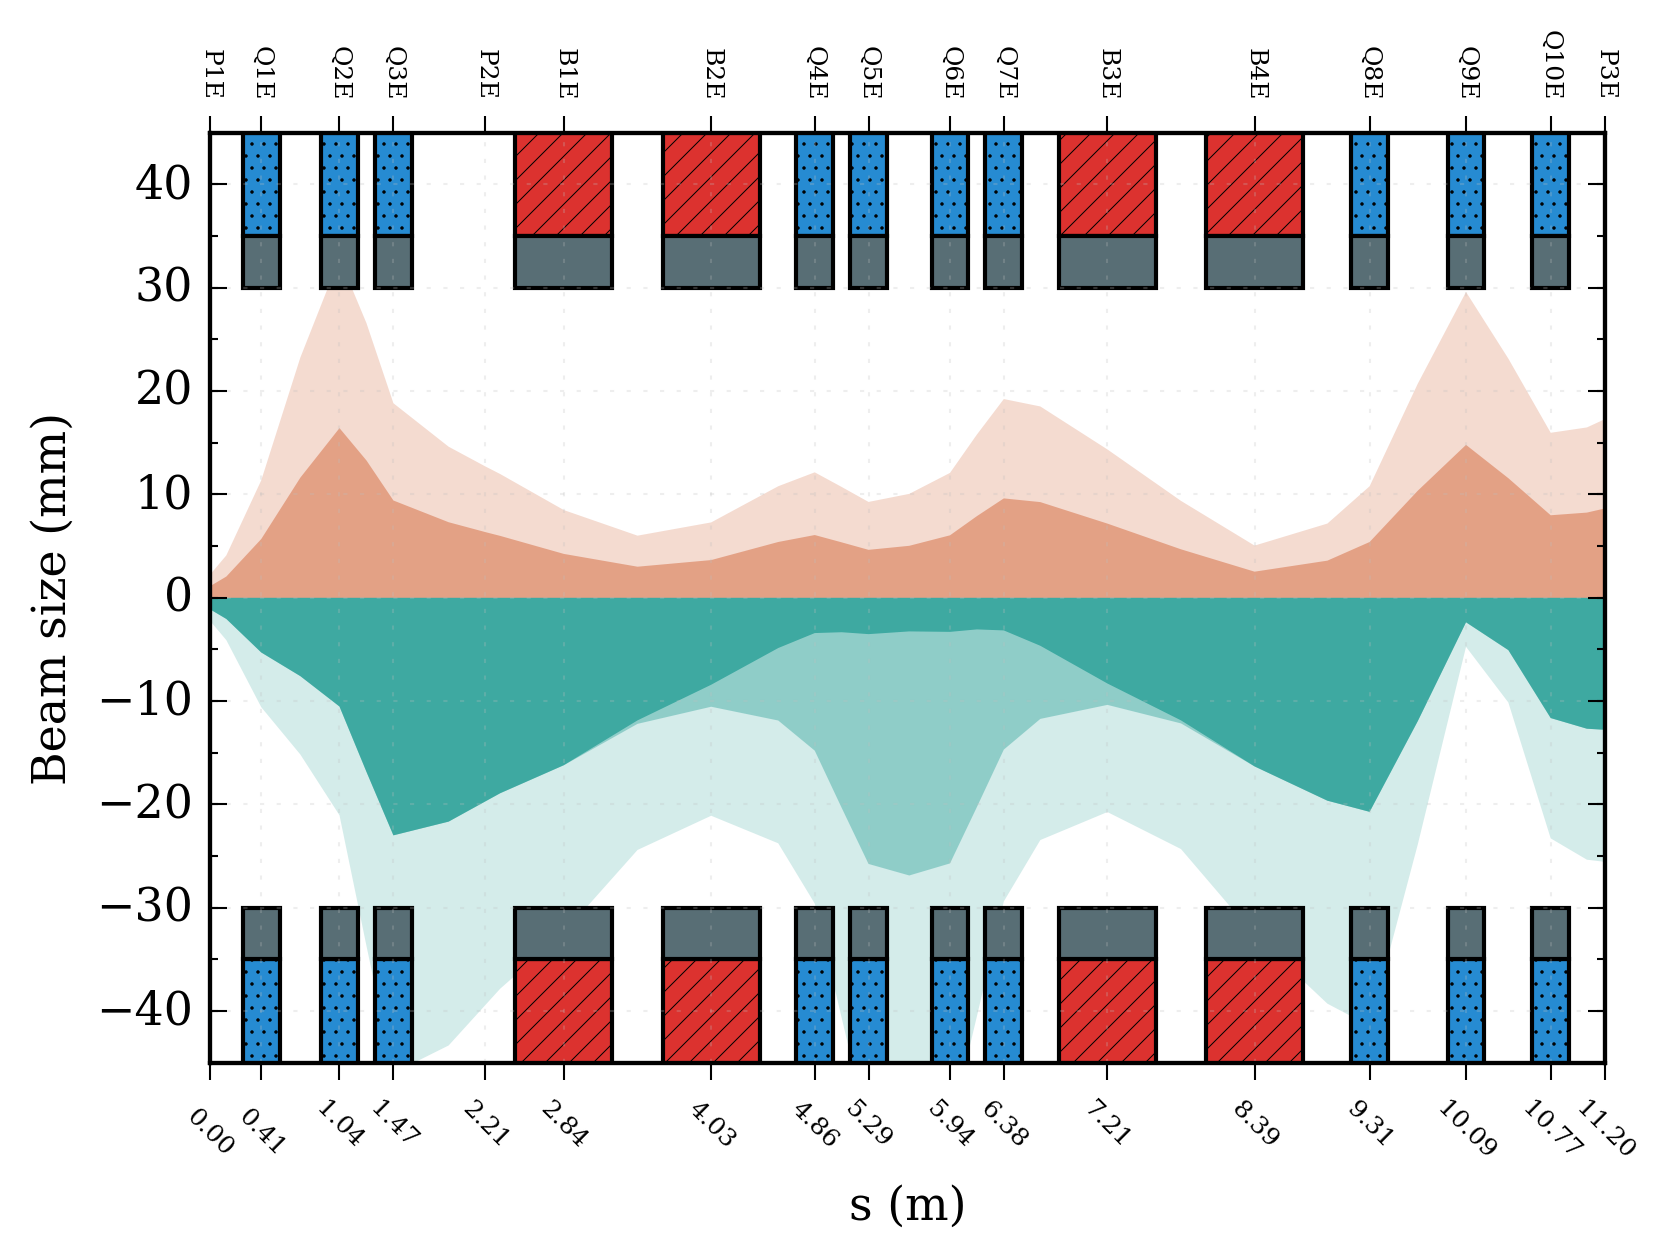

In [4]:
brho = georges.physics.momentum_to_brho(georges.physics.energy_to_momentum(177.5))
context = {
    'PARTICLE': 'PROTON',
    'PC': georges.physics.energy_to_momentum(177.5),
    'BETAX'   : 0.0846155,
    'BETAY'   : 0.0846155,
    'ALPHAX': 0.0,
    'ALPHAY': 0.0,
    'DELTAP': 0.0,
    'DPP': 0.5e-2,
    'IQ1E': 2.741/10/brho/0.0325*0.297/0.295,
    'IQ2E': -5.745/10/brho/0.0325*0.297/0.295,
    'IQ3E': 4.079/10/brho/0.0325*0.297/0.295,
    'IQ47E': -3.062/10/brho/0.0325,
    'IQ56E': 2.66/10/brho/0.0325,
    'IQ8E': 3.5484/10/brho/0.0325,
    'IQ9E': -4.0276/10/brho/0.0325,
    'IQ10E': 4.0352/10/brho/0.0325,
    'MOMENTUM_SLITS_OPENING' : 1.015,
    'DIVERGENCE_SLITS_OPENING_X' : 1.015,
    'DIVERGENCE_SLITS_OPENING_Y' : 1.015,
    'N_TRACKING': 5000,
    'EMITX': 14.3e-6,
    'EMITY': 14.3e-6,
}
m = georges.madx.Madx(madx='/usr/local/bin/madx', path=PATH, context=context)
bl = georges.Beamline('ess', path=PATH, prefix='generic', elements='elements')
bl_twiss= georges.madx.twiss(line=bl, madx=m)

from georges.plotting import *
with plt.style.context('word'):
    fig = plt.figure(1)
    
    ax1 = fig.add_subplot(111)
    prepare(ax1, bl)
    aperture(ax1, bl)
    twiss(ax1, bl_twiss, context)
    #track(ax1, bl, context)

In [2]:
b = Beam(energy=200).from_5d_multigaussian_distribution(20,
                                               XRMS=0.01,
                                               PXRMS=0.001,
                                               YRMS=0.01,
                                               PYRMS=0.001,
                                               DPPRMS=0.00)

context = {
    'PARTICLE': 'PROTON',
    #'PC': energy_to_momentum(177.5),
    'BETAX'   : 0.0846155,
    'BETAY'   : 0.0846155,
    'ALPHAX': 0.0,
    'ALPHAY': 0.0,
    'DELTAP': 0.0,
    'DPP': 0.5e-2,
    'IQ1G': 2.741, # K1 IQ1G
    'MOMENTUM_SLITS_OPENING' : 0.015,
    'DIVERGENCE_SLITS_OPENING_X' : 0.015,
    'DIVERGENCE_SLITS_OPENING_Y' : 0.015,
    'N_TRACKING': 5000,
    'EMITX': 14.3e-6,
    'EMITY': 14.3e-6,
    'BETAREL': 0.5,
}

bl = Beamline('cgtr', beam=b, elements='beamlines/elements', path=PATH, prefix='beamlines/generic')
# If using a direct path
#bl = Beamline('cgtr', beam=b, elements='elements', path='path/to/files')


In [3]:
bl.line

,TYPE,AT_CENTER,CIRCUIT,CLASS,LENGTH,APERTYPE,APERTURE,TILT,RHO,ANGLE,...,E1,E2,HGAP,THICK,PLUG,CHAMBER,AT_ENTRY,AT_EXIT,ORBIT_LENGTH,PHYSICAL
NAME,,,,,,,,,,,,,,,,,,,,,
DEG,MARKER,0.000000,NaN,MARKER,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,True
Q1G,CGTR_QUAD,1.142187,IQ1G,QUADRUPOLE,0.284375,CIRCLE,0.035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,K1,0.005,1.000000,1.284375,0.284375,True
Q2G,CGTR_QUAD,1.742188,IQ2G,QUADRUPOLE,0.284375,CIRCLE,0.035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,K1,0.005,1.600000,1.884375,0.284375,True
B1G,CGTR_B40,3.138876,NaN,SBEND,NaN,RECTANGLE,"[0.04, 0.02]",0.0,1500.0,0.698132,...,NaN,NaN,0.023,True,NaN,0.005,2.615278,3.662475,1.047198,True
Q3G,CGTR_QUAD,4.071875,IQ3G,QUADRUPOLE,0.284375,CIRCLE,0.035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,K1,0.005,3.929688,4.214063,0.284375,True
Q4G,CGTR_QUAD,4.687875,IQ4G,QUADRUPOLE,0.284375,CIRCLE,0.035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,K1,0.005,4.545688,4.830063,0.284375,True
Q5G,CGTR_QUAD_LONG,5.411875,IQ5G,QUADRUPOLE,0.495000,CIRCLE,0.035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,K1,0.005,5.164375,5.659375,0.495000,True
Q6G,CGTR_QUAD,6.136875,IQ6G,QUADRUPOLE,0.284375,CIRCLE,0.035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,K1,0.005,5.994687,6.279062,0.284375,True
Q7G,CGTR_QUAD,6.786875,IQ7G,QUADRUPOLE,0.284375,CIRCLE,0.035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,K1,0.005,6.644687,6.929062,0.284375,True


In [4]:
bl.twiss
bl.track;

NAME
DEG           <georges.beam.Beam object at 0x105d722e8>
CGTR$START                                          NaN
DRIFT_0                                             NaN
Q1G           <georges.beam.Beam object at 0x105d72358>
DRIFT_1                                             NaN
Q2G           <georges.beam.Beam object at 0x105dd1438>
DRIFT_2                                             NaN
B1G           <georges.beam.Beam object at 0x105dd1470>
DRIFT_3                                             NaN
Q3G           <georges.beam.Beam object at 0x105dd12b0>
DRIFT_4                                             NaN
Q4G           <georges.beam.Beam object at 0x105dd16a0>
DRIFT_5                                             NaN
Q5G           <georges.beam.Beam object at 0x105dd1630>
DRIFT_6                                             NaN
Q6G           <georges.beam.Beam object at 0x105dd19e8>
DRIFT_7                                             NaN
Q7G           <georges.beam.Beam object at 

ValueError: Wrong number of items passed 40, placement implies 34

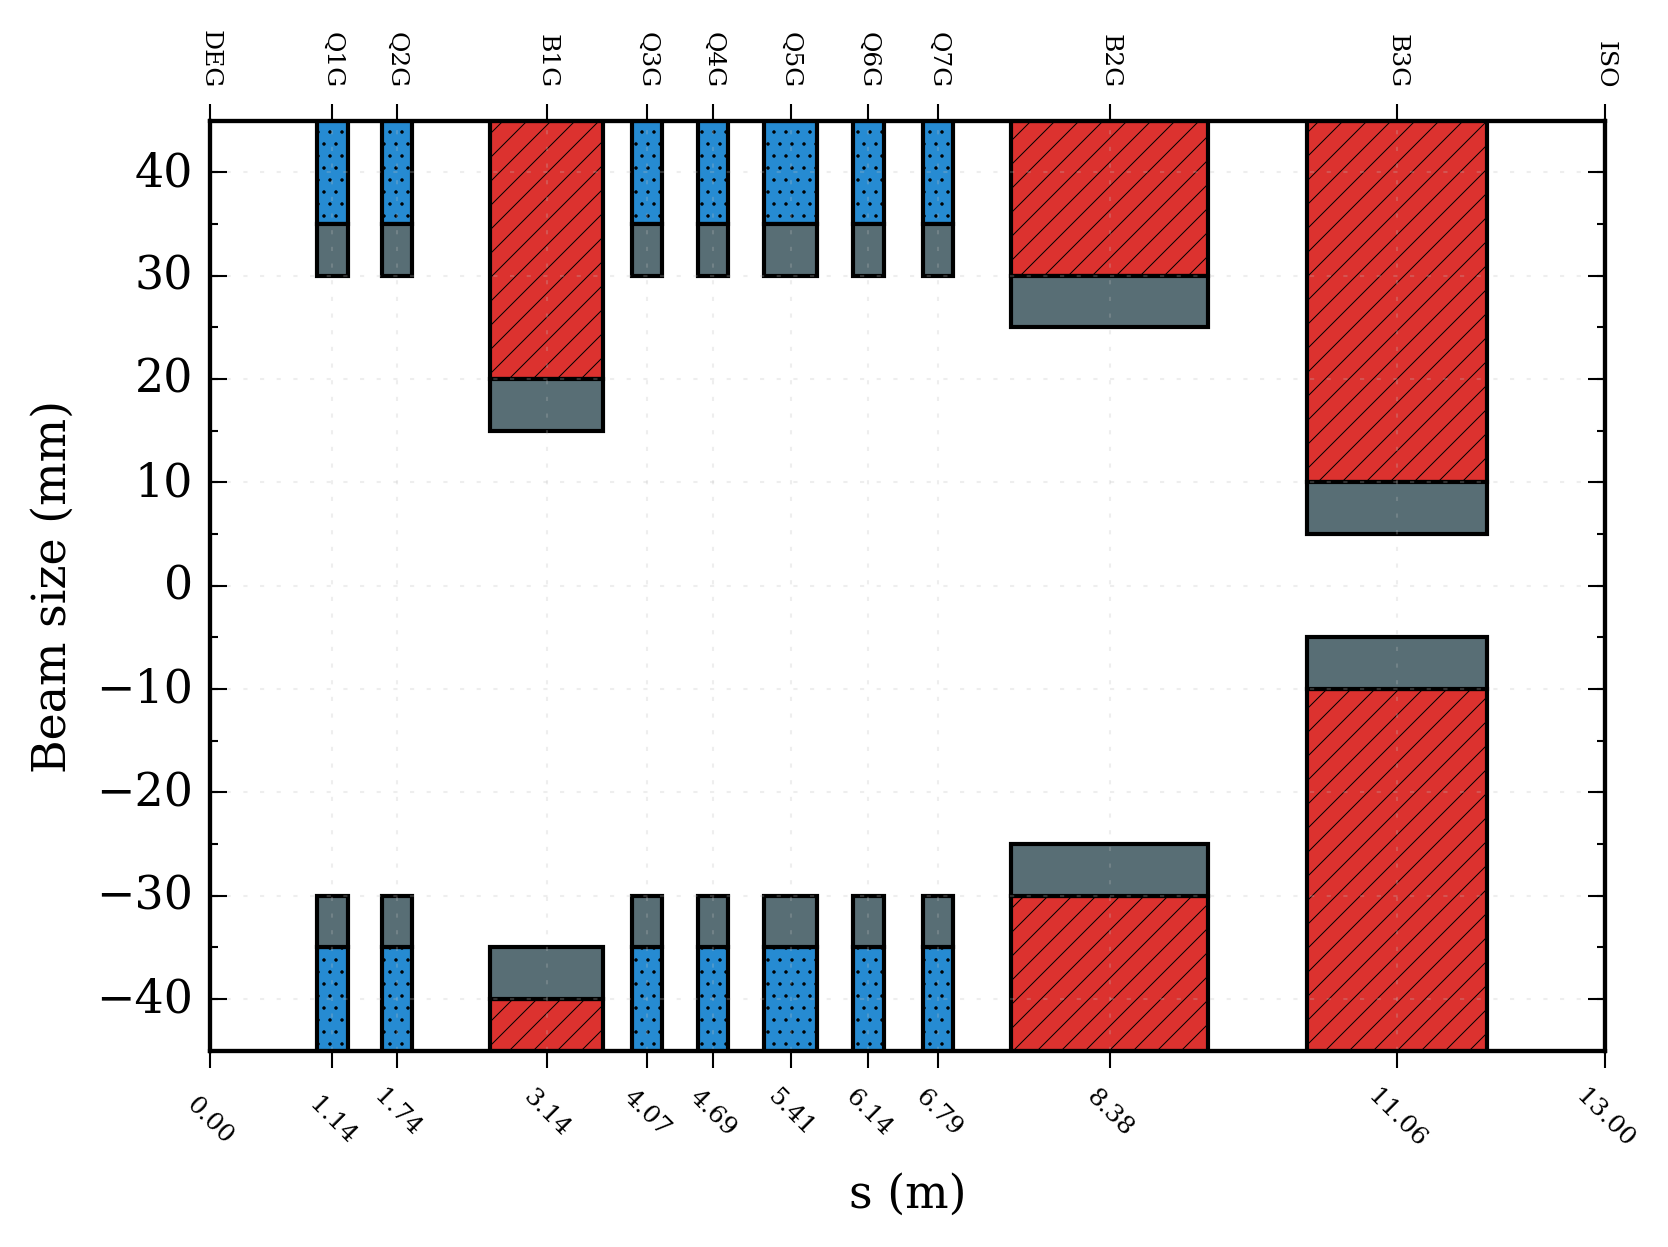

In [9]:
with plt.style.context('word'):
    fig = plt.figure(1)
    
    ax1 = fig.add_subplot(111)
    prepare(ax1, bl)
    aperture(ax1, bl)
    #twiss(ax1, bl, context)
    track(ax1, bl, context)